# Packages setup

First of all make sure you're using a GPU hardware accelerator. This tutorial has been developed with T4 GPU.

You can change hardware accelerator by clicking on the bottom right button (here, it displays Python version). Then go to "Change runtime type" and select the hardware. Then, restart session.

We will install conda (colab for this notebook), UAMMD-structured and pyUAMMD packages

# Free Helix

## Libraries and functions
First, let's import the necessary libraries:

In [1]:
import pyUAMMD
import numpy as np
import matplotlib.pyplot as plt

### Specific Functions

Below are utility functions for generating helical coordinates and calculating dihedral angles. These functions are defined here for use during the simulation setup.

In [2]:
def make_helix(N, radius=1.0, pitch=3.0, loops=3):
    """
    Generates 3D multiblob helix coordinates

    Parameters:
    -----------
    N : int
        Total number of particles
    radius : float
        Helix radius
    pitch : float
        pitch (distance between loops).
    loops : int
        Number of complete loops

    Returns:
    --------
    coords : np.ndarray (N,3)
        [x,y,z] particles' coordinates
    """
    assert N > 0, "Particle number must be positive"
    assert int(N/loops) == N/loops, "Number of particles mus be multiple of number of loops"

    delta_theta = 2 * np.pi * loops / N   # Angular separation between particles (measured from helix axis)
    thetas = np.arange(N) * delta_theta   # Angles array

    # Helix particles' coordinates
    x = radius * np.cos(thetas)
    y = radius * np.sin(thetas)
    z = (pitch / (2*np.pi)) * thetas

    return np.column_stack((x, y, z))


def dihedral(p0,p1,p2,p3):
    """
    Dihedral angle constructor between 4 particles

    Parameters:
    -----------
    pi: particle i positions

    Returns:
    --------
    angle : dihedral angle
    """
    b0 = p1 - p0
    b1 = p2 - p1
    b2 = p3 - p2

    n1 = np.cross(b0, b1)
    n2 = np.cross(b1, b2)

    n1_norm = n1 / np.linalg.norm(n1)
    n2_norm = n2 / np.linalg.norm(n2)
    m1 = np.cross(n1_norm, b1/np.linalg.norm(b1))
    x = np.dot(n1_norm, n2_norm)
    y = np.dot(m1, n2_norm)
    angle = np.atan2(y, x)

    return angle

## Parameters

Define the key parameters for our Helix simulation:

### Helix Parameters
First, we characterize our helix

In [3]:
# Helix geometry
nBeadsPerLoop = 15
loops = 3
nBeads = nBeadsPerLoop * loops
pitch = 8
sigma = 1.0 # Bead diameter (and bond length)
helix_coords = make_helix(N=nBeads, radius=2*sigma, pitch=pitch, loops=loops)
helix_coords -= np.mean(helix_coords, axis=0) # Center the helix coords



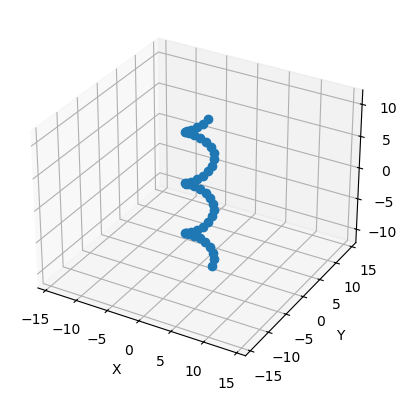

In [4]:
# 3D plot of the helix
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(helix_coords[:,0], helix_coords[:,1], helix_coords[:,2], marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.axis('equal')
plt.show()

### Simulation Parameters
Parameters related with the simulation development

In [5]:

L = 4*np.max(np.abs(helix_coords)) + 2.0*sigma  # Box size

timeStep = 0.01
frictionConstant = 3*np.pi
nSteps = 30000
nStepsInfo = 3000  # Frequency of info output
nStepsOutput = 100 # Frequency of trajectory output

T = 0.01    # Temperature
Kb = 100.0  # Pair bond strength
Ka = 100.0  # Angle strength (bending rigidity)
Kc = 100.0    # Dihedral strength

## Creating the Simulation

Now, let's create our UAMMD-Structured simulation and set up its various components.
For that, we will use a `pyUAMMD` simulation object

In [6]:
# Initialize the simulation object
simulation = pyUAMMD.simulation()

# Set up the system information (give it a name)
simulation["system"] = {
    "info": {
        "type": ["Simulation", "Information"],
        "parameters": {"name": "Free Helix Simulation"}
    }
}


The `pyUAMMD` simulation object is a Python dictionary, allowing you to access and modify its components using standard dictionary operations. For example, you can print, retrieve or update simulation entities directly by referencing their keys.

In [7]:
print("Simulation named:", simulation["system"]["info"]["parameters"]["name"])

Simulation named: Free Helix Simulation


## Global
Here we will define overall aspects of the simulation

In [8]:
# Define global parameters
simulation["global"] = {
    # Set the unit system (in this case, we're using reduced units)
    "units": {"type": ["Units", "None"]},

    # Define particle types
    "types": {
        "type": ["Types", "Basic"],
        "labels": ["name", "mass", "radius", "charge"],
        "data": [["A", 1.0, sigma/2.0, 0.0]]
    },

    # Set the ensemble (NVT: constant Number of particles, Volume, and Temperature)
    "ensemble": {
        "type": ["Ensemble", "NVT"],
        "labels": ["box", "temperature"],
        "data": [[[L, L, L], T]]
    }
}

## Integrator

We set a Langevin integrator to evolve the system, specifying both the time step and friction constant for the dynamics. Additionally, the integration schedule determines the total number of simulation steps to be executed.

In [9]:
# Set up the integrator (Langevin dynamics)
simulation["integrator"] = {
    "bbk": {
        "type": ["Langevin", "BBK"],
        "parameters": {
            "timeStep": timeStep,
            "frictionConstant": frictionConstant
        }
    },
    # Define the integration schedule
    "schedule": {
        "type": ["Schedule", "Integrator"],
        "labels": ["order", "integrator", "steps"],
        "data": [[1, "bbk", nSteps]]
    }
}

## State and Topology

We´ll set the state positions and multiple bonds of the helix

### Initialization

We initialize the state and topology entities of the simulation.

In [10]:
simulation["state"] = {
    "labels": ["id", "position"],
    "data": []
}

simulation["topology"] = {
    "structure": {
        "labels": ["id", "type", "modelId"],
        "data": []
    }
}

We modify the simulation dictionary by referencing its keys to establish particle positions and define the topology structure. In this setup, all particles are assigned to a single group representing the helix.

In [11]:
particleId = 0
for j in range(int(nBeads)):
    # Place beads along the z-axis, centered at the origin
    simulation["state"]["data"].append([particleId, [helix_coords[j, 0], helix_coords[j, 1], helix_coords[j, 2]]])
    simulation["topology"]["structure"]["data"].append([particleId, "A", j])
    particleId += 1

### Initialize bonds

We create a `forceField`section in topology entity with different bond entries

In [12]:
simulation["topology"]["forceField"] = {}

# Harmonic bonds
simulation["topology"]["forceField"]["bonds"] = {
    "type": ["Bond2", "Harmonic"],
    "parameters": {},
    "labels": ["id_i", "id_j", "K", "r0"],
    "data": []
}

# Angular bonds
simulation["topology"]["forceField"]["angles"] = {
    "type": ["Bond3", "KratkyPorod"],
    "parameters": {},
    "labels": ["id_i", "id_j", "id_k", "K"],
    "data": []
}

# Dihedral_bonds
dihedral_angle = dihedral(helix_coords[0], helix_coords[1], helix_coords[2], helix_coords[3])
simulation["topology"]["forceField"]["dihedrals"] = {
    "type": ["Bond4", "DihedralCommon_n_K_phi0"],
    "parameters": {"n": 1,
                   "K": Kc*0,
                   "phi0": dihedral_angle},
    "labels": ["id_i", "id_j", "id_k", "id_l"],
    "data": []
}

### Bonds definition

In [13]:
particleId = 0
r0 = np.linalg.norm(np.diff(helix_coords, axis=0), axis=1)  # N-1 valores
for j in range(int(nBeads) - 1):
    simulation["topology"]["forceField"]["bonds"]["data"].append([particleId, particleId + 1, Kb, r0[j]])
    particleId += 1

particleId = 0
r_pitch = np.linalg.norm((helix_coords[0]-helix_coords[nBeadsPerLoop]), axis=0)
for j in range(int(nBeads) - nBeadsPerLoop):
    simulation["topology"]["forceField"]["bonds"]["data"].append([particleId, particleId + nBeadsPerLoop, Kb, r_pitch])
    particleId += 1

particleId = 0
for j in range(int(nBeads) - 2):
    simulation["topology"]["forceField"]["angles"]["data"].append([particleId, particleId + 1, particleId + 2, Ka])
    particleId += 1

particleId = 0
for j in range(int(nBeads) - 2*nBeadsPerLoop):
    simulation["topology"]["forceField"]["angles"]["data"].append([particleId, particleId + nBeadsPerLoop, particleId + 2*nBeadsPerLoop, Ka])
    particleId += 1

particleId = 0
for j in range(int(nBeads) - 3):
    simulation["topology"]["forceField"]["dihedrals"]["data"].append([particleId, particleId + 1, particleId + 2, particleId + 3])
    particleId += 1

## Simulation Steps

We define operations to perform during the simulation. In this example, some screen info logs and trajectory outputs (xyz format)

In [14]:
simulation["simulationStep"] = {
    # Output simulation information periodically
    "info": {
        "type": ["UtilsStep", "InfoStep"],
        "parameters": {"intervalStep": nStepsInfo}
    },
    # Save trajectory data periodically
    "output": {
        "type": ["WriteStep", "WriteStep"],
        "parameters": {
            "intervalStep": nStepsOutput,
            "outputFilePath": "output",
            "outputFormat": "xyz"
        }
    }
}

## Simulation writing

We generate `simulation.json` file. After that we can use `UAMMDlauncher simulation.json` command to carry on the simulation and generate the specified output

In [15]:
print()
print("Writing simulation file...")
simulation.write("simulation.json")
print("Simulation file created successfully!")
print()

16/09/2025 09:33:09 - pyUAMMD - WARNING - Writing with legacy 



Writing simulation file...
Simulation file created successfully!



In [16]:
!UAMMDlauncher simulation.json

[MESSAGE] [Input] File simulation.json loaded
[WARNING] [Simulation] Simulation has no backup, will not restart if it fails.
[MESSAGE] ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
[MESSAGE] ╻ ╻┏━┓┏┳┓┏┳┓╺┳┓
[MESSAGE] ┃ ┃┣━┫┃┃┃┃┃┃ ┃┃ Version: 2.5
[MESSAGE] ┗━┛╹ ╹╹ ╹╹ ╹╺┻┛
[MESSAGE] Compiled at: May 30 2025 09:39:25
[MESSAGE] Compiled in double precision mode
[MESSAGE] Computation started at Tue Sep 16 09:33:14 2025

[MESSAGE] [System] CUDA initialized
[MESSAGE] [System] Using device: NVIDIA GeForce RTX 3080 with id: 0
[MESSAGE] [System] Compute capability of the device: 8.6
[MESSAGE] ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ 
[MESSAGE] [Input] File simulation.json loaded
[MESSAGE] [ExtendedSystem] (system) Name: Free Helix Simulation
[MESSAGE] [ExtendedSystem] (system) Seed: 1758007994221040146
[MESSAGE] [GlobalDataBase] Fundamental not specified, using default fundamental, "Time"
[WARNING] [Time] No timeStep specified, using 0.0 as default.
[MESSAGE] [Ba

### Film Function

In [17]:
import matplotlib.animation as animation
import os

def create_animation(fig, ax, lines):
    """
    Create an animation from the XYZ file data.

    Args:
        fig (matplotlib.figure.Figure): The figure object.
        ax (matplotlib.axes.Axes): The axes object.
        lines (list): List of lines from the XYZ file.

    Returns:
        ani (matplotlib.animation.FuncAnimation): The animation object.
    """

    # Extract the number of atoms and their coordinates
    num_atoms = int(lines[0])
    num_lines = len(lines)
    num_frames = int(num_lines / (num_atoms + 2))

    # Create a list to hold the atom data for each frame
    atom_data = np.zeros((num_frames, num_atoms, 3))

    # Read the atom data for each frame
    for i in range(num_frames):
        start_line = i * (num_atoms + 2) + 2
        end_line = start_line + num_atoms
        atom_data[i] = np.array([list(map(float, line.split()[1:])) for line in lines[start_line:end_line]])

    # Function to update the plot for each frame
    def update(frame):
        ax.cla()  # Clear the axis
        ax.set_title("Half Pipe Simulation")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")


        # Plot the atoms for the current frame
        ax.scatter(atom_data[frame][:, 0], atom_data[frame][:, 1], atom_data[frame][:, 2], c='blue', marker='o')

        # Set axis limits using the min and max coordinates of the initial frame
        ax.set_xlim([np.min(atom_data[0][:, 0])*10, np.max(atom_data[0][:, 0])*10])
        ax.set_ylim([np.min(atom_data[0][:, 1])*10, np.max(atom_data[0][:, 1])*10])
        ax.set_zlim([np.min(atom_data[0][:, 2])*1.5, np.max(atom_data[0][:, 2])])
        ax.set_aspect('equal')
        ax.view_init(elev=0, azim=45)
        ax.grid(False)

    # Create the animation object
    ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=100)

    return ani


def generate_film_from_xyz(xyz_file, name):

    """
    Generate a film from an XYZ simulation file.

    Args:
        xyz_file (str): Path to the XYZ file.

    Returns:
        None
    """

    # Check if the file exists
    if not os.path.isfile(xyz_file):
        raise FileNotFoundError(f"The file {xyz_file} does not exist.")

    # Read the XYZ file
    with open(xyz_file, 'r') as file:
        lines = file.readlines()

    # Graph the initial frame and stablish the axis limits anfd figure configuration
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={'projection': '3d'})

    # Create or check if an animation directory exists
    animation_dir = os.path.join(os.path.dirname(xyz_file), 'animations')
    if not os.path.exists(animation_dir):
        os.makedirs(animation_dir)

    # Create the animation
    ani = create_animation(fig, ax, lines)

    # Save the animation
    ani.save(os.path.join(animation_dir, name), writer='ffmpeg', fps=30)



## Visualization
We will generate an mp3 file

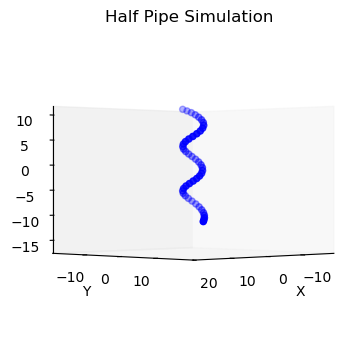

In [18]:
generate_film_from_xyz('output.xyz', "free_helix.mp4")

# Modifying simulation to include gravity
- Gravity: as an external constant downforce
- Wall: Only for particles "A", the whole helix group

We expect the angular bonds to relaxate and an stabñe fall of the helix

In [ ]:
# Set up gravity
simulation["topology"]["forceField"]["gravity"] = {
    "type": ["External", "ConstantForce"],
    "parameters": {"constantForce": [0.0, 0.0, -1]}
}

simulation["simulationStep"] = {
    # Output simulation information periodically
    "info": {
        "type": ["UtilsStep", "InfoStep"],
        "parameters": {"intervalStep": nStepsInfo}
    },
    # Save trajectory data periodically
    "output": {
        "type": ["WriteStep", "WriteStep"],
        "parameters": {
            "intervalStep": nStepsOutput*2,
            "outputFilePath": "gravity_output",
            "outputFormat": "xyz",
            "pbc": True
        }
    }
}


[WARNING] UAMMD-structured Python wrapper is not compatible with UAMMD-structured self restarting mechanism
[MESSAGE] ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
[MESSAGE] ╻ ╻┏━┓┏┳┓┏┳┓╺┳┓
[MESSAGE] ┃ ┃┣━┫┃┃┃┃┃┃ ┃┃ Version: 2.5
[MESSAGE] ┗━┛╹ ╹╹ ╹╹ ╹╺┻┛
[MESSAGE] Compiled at: May 30 2025 09:39:25
[MESSAGE] Compiled in double precision mode
[MESSAGE] Computation started at Tue Sep 16 09:41:57 2025

[MESSAGE] [System] CUDA initialized
[MESSAGE] [System] Using device: NVIDIA GeForce RTX 3080 with id: 0
[MESSAGE] [System] Compute capability of the device: 8.6
[MESSAGE] ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ 
[MESSAGE] [ExtendedSystem] (system) Name: Free Helix Simulation
[MESSAGE] [ExtendedSystem] (system) Seed: 1758008517232799317
[MESSAGE] [GlobalDataBase] Fundamental not specified, using default fundamental, "Time"
[WARNING] [Time] No timeStep specified, using 0.0 as default.
[MESSAGE] [Basic] Loaded type A, mass: 1.000000, radius: 0.500000, charge: 0

pyUAMMD simulation objects have a `.run`method to execute the simulation, as an alternative to command-line execution

In [ ]:

simulation.run()

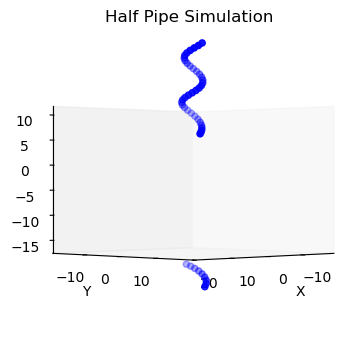

In [22]:
generate_film_from_xyz('gravity_output.xyz', "free_helix_gravity.mp4")

# Modifying simulation to include hydrodynamics

- An hydrodynamic integrator
- Incompresssible fluid
- periodic boundary conditions (pbc)

We expect the helix to spin as falling

In [ ]:
simulation["integrator"]["bbk"] = {
    "type":["FluctuatingHydrodynamics","IncompressibleInertialCoupling"],
    "parameters":{
    "timeStep": timeStep,
    "viscosity": 1.0,
    "density": 1.0,
    "hydrodynamicRadius": 0.5*sigma,
    "sumThermalDrift": False,
    "removeTotalMomentum": True
    }
}

simulation["integrator"]["schedule"]["data"] = [[1, "bbk", nSteps]]



simulation["simulationStep"] = {
    # Output simulation information periodically
    "info": {
        "type": ["UtilsStep", "InfoStep"],
        "parameters": {"intervalStep": nStepsInfo}
    },
    # Save trajectory data periodically
    "output": {
        "type": ["WriteStep", "WriteStep"],
        "parameters": {
            "intervalStep": nStepsOutput,
            "outputFilePath": "gravityHyd_output",
            "outputFormat": "xyz",
            "pbc": True
        }
    }
}

simulation.run()

[WARNING] UAMMD-structured Python wrapper is not compatible with UAMMD-structured self restarting mechanism
[MESSAGE] ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
[MESSAGE] ╻ ╻┏━┓┏┳┓┏┳┓╺┳┓
[MESSAGE] ┃ ┃┣━┫┃┃┃┃┃┃ ┃┃ Version: 2.5
[MESSAGE] ┗━┛╹ ╹╹ ╹╹ ╹╺┻┛
[MESSAGE] Compiled at: May 30 2025 09:39:25
[MESSAGE] Compiled in double precision mode
[MESSAGE] Computation started at Sun Sep 14 23:20:39 2025

[MESSAGE] [System] CUDA initialized
[MESSAGE] [System] Using device: NVIDIA GeForce RTX 3080 with id: 0
[MESSAGE] [System] Compute capability of the device: 8.6
[MESSAGE] ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ 
[MESSAGE] [ExtendedSystem] (system) Name: Free Helix Simulation
[MESSAGE] [ExtendedSystem] (system) Seed: 1757884839746150601
[MESSAGE] [GlobalDataBase] Fundamental not specified, using default fundamental, "Time"
[WARNING] [Time] No timeStep specified, using 0.0 as default.
[MESSAGE] [Basic] Loaded type A, mass: 1.000000, radius: 0.500000, charge: 0

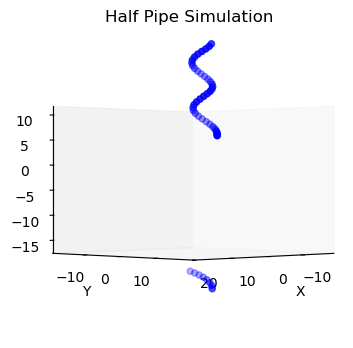

In [34]:
generate_film_from_xyz('gravityHyd_output.xyz', "gravityHyd_helix.mp4")

# Batching

## Simulation function

In [ ]:
# Initialize the simulation object
T = 1.5

def create_simulation():
  simulation = pyUAMMD.simulation()

  # Set up the system information (give it a name)
  simulation["system"] = {
      "info": {
          "type": ["Simulation", "Information"],
          "parameters": {"name": "Free Helix Simulation"}
      }
  }

  # Define global parameters
  simulation["global"] = {
      # Set the unit system (in this case, we're using reduced units)
      "units": {"type": ["Units", "None"]},

      # Define particle types
      "types": {
          "type": ["Types", "Basic"],
          "labels": ["name", "mass", "radius", "charge"],
          "data": [["A", 1.0, sigma/2.0, 0.0]]
      },

      # Set the ensemble (NVT: constant Number of particles, Volume, and Temperature)
      "ensemble": {
          "type": ["Ensemble", "NVT"],
          "labels": ["box", "temperature"],
          "data": [[[L, L, L], T]]
      }
  }

  # Set up the integrator (Langevin dynamics)
  simulation["integrator"] = {
      "bbk": {
          "type": ["Langevin", "BBK"],
          "parameters": {
              "timeStep": timeStep,
              "frictionConstant": frictionConstant
          }
      },
      # Define the integration schedule
      "schedule": {
          "type": ["Schedule", "Integrator"],
          "labels": ["order", "integrator", "steps"],
          "data": [[1, "bbk", nSteps]]
      }
  }

  simulation["state"] = {
      "labels": ["id", "position"],
      "data": []
  }

  simulation["topology"] = {
      "structure": {
          "labels": ["id", "type", "modelId"],
          "data": []
      }
  }

  particleId = 0
  for j in range(int(nBeads)):
      # Place beads along the z-axis, centered at the origin
      simulation["state"]["data"].append([particleId, [helix_coords[j, 0], helix_coords[j, 1], helix_coords[j, 2]]])
      simulation["topology"]["structure"]["data"].append([particleId, "A", j])
      particleId += 1

  simulation["topology"]["forceField"] = {}

  # Harmonic bonds
  simulation["topology"]["forceField"]["bonds"] = {
      "type": ["Bond2", "Harmonic"],
      "parameters": {},
      "labels": ["id_i", "id_j", "K", "r0"],
      "data": []
  }

  # Angular bonds
  simulation["topology"]["forceField"]["angles"] = {
      "type": ["Bond3", "KratkyPorod"],
      "parameters": {},
      "labels": ["id_i", "id_j", "id_k", "K"],
      "data": []
  }

  # Dihedral_bonds
  dihedral_angle = dihedral(helix_coords[0], helix_coords[1], helix_coords[2], helix_coords[3])
  simulation["topology"]["forceField"]["dihedrals"] = {
      "type": ["Bond4", "DihedralCommon_n_K_phi0"],
      "parameters": {"n": 1,
                    "K": Kc*0,
                    "phi0": dihedral_angle},
      "labels": ["id_i", "id_j", "id_k", "id_l"],
      "data": []
  }

  particleId = 0
  r0 = np.linalg.norm(np.diff(helix_coords, axis=0), axis=1)  # N-1 valores
  for j in range(int(nBeads) - 1):
      simulation["topology"]["forceField"]["bonds"]["data"].append([particleId, particleId + 1, Kb, r0[j]])
      particleId += 1

  particleId = 0
  r_pitch = np.linalg.norm((helix_coords[0]-helix_coords[nBeadsPerLoop]), axis=0)
  for j in range(int(nBeads) - nBeadsPerLoop):
      simulation["topology"]["forceField"]["bonds"]["data"].append([particleId, particleId + nBeadsPerLoop, Kb, r_pitch])
      particleId += 1

  particleId = 0
  for j in range(int(nBeads) - 2):
      simulation["topology"]["forceField"]["angles"]["data"].append([particleId, particleId + 1, particleId + 2, Ka])
      particleId += 1

  particleId = 0
  for j in range(int(nBeads) - 2*nBeadsPerLoop):
      simulation["topology"]["forceField"]["angles"]["data"].append([particleId, particleId + nBeadsPerLoop, particleId + 2*nBeadsPerLoop, Ka])
      particleId += 1

  particleId = 0
  for j in range(int(nBeads) - 3):
      simulation["topology"]["forceField"]["dihedrals"]["data"].append([particleId, particleId + 1, particleId + 2, particleId + 3])
      particleId += 1

  simulation["simulationStep"] = {
      # Output simulation information periodically
      "info": {
          "type": ["UtilsStep", "InfoStep"],
          "parameters": {"intervalStep": nStepsInfo}
      },
      # Save trajectory data periodically
      "output": {
          "type": ["WriteStep", "WriteStep"],
          "parameters": {
              "intervalStep": nStepsOutput,
              "outputFilePath": "output",
              "outputFormat": "xyz"
          }
      }
  }

  # Set up gravity
  simulation["topology"]["forceField"]["gravity"] = {
      "type": ["External", "ConstantForce"],
      "parameters": {"constantForce": [0.0, 0.0, -1]}
  }

  # Set up wall
  simulation["topology"]["forceField"]["wall"] = {
      "type": ["Surface", "SurfaceWCAType2"],
      "parameters": {"surfacePosition": -pitch*loops*0.6},
      "labels": ["name", "epsilon", "sigma"],
      "data": [
          ["A", 5.0, 0.2]
      ]
  }

  return simulation

total_sim = pyUAMMD.simulation()
total_sim = create_simulation()
for n in range(10):
    sim_i = create_simulation()
    total_sim.append(sim_i)

total_sim.write("simulation_batching.json")


16/09/2025 00:36:18 - pyUAMMD - WARNING - Writing with legacy 


In [51]:
!UAMMDlauncher simulation_batching.json

[MESSAGE] [Input] File simulation_batching.json loaded
[WARNING] [Simulation] Simulation has no backup, will not restart if it fails.
[MESSAGE] ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
[MESSAGE] ╻ ╻┏━┓┏┳┓┏┳┓╺┳┓
[MESSAGE] ┃ ┃┣━┫┃┃┃┃┃┃ ┃┃ Version: 2.5
[MESSAGE] ┗━┛╹ ╹╹ ╹╹ ╹╺┻┛
[MESSAGE] Compiled at: May 30 2025 09:39:25
[MESSAGE] Compiled in double precision mode
[MESSAGE] Computation started at Tue Sep 16 00:36:22 2025

[MESSAGE] [System] CUDA initialized
[MESSAGE] [System] Using device: NVIDIA GeForce RTX 3080 with id: 0
[MESSAGE] [System] Compute capability of the device: 8.6
[MESSAGE] ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ 
[MESSAGE] [Input] File simulation_batching.json loaded
[MESSAGE] [ExtendedSystem] (system) Name: Free Helix Simulation_Free Helix Simulation_Free Helix Simulation_Free Helix Simulation_Free Helix Simulation_Free Helix Simulation_Free Helix Simulation_Free Helix Simulation_Free Helix Simulation_Free Helix Simulation_Free Heli

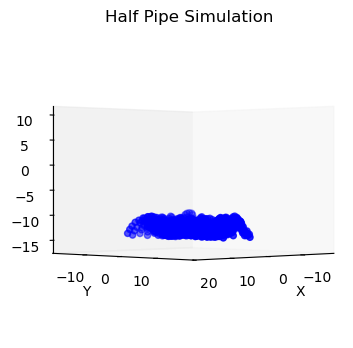

In [52]:
generate_film_from_xyz('output.xyz', "batching_free_helix_gravity.mp4")